# Point Cloud 추출

이 노트북에서는 STL 파일에서 mesh를 읽고, surface mesh에서 point cloud를 추출하는 방법을 다룹니다.

## 1. 필요한 라이브러리 import

In [3]:
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Jupyter 환경에서 3D 플롯을 위한 설정
pv.set_jupyter_backend('static')
pv.global_theme.show_edges = True
#pv.global_theme.show_grid = True

## 2. STL 파일에서 mesh 로드

In [4]:
# STL 파일 경로 설정
stl_file = Path("../../data/10_30.stl")

# STL 파일 존재 확인
if not stl_file.exists():
    raise FileNotFoundError(f"STL 파일을 찾을 수 없습니다: {stl_file}")

print(f"STL 파일 경로: {stl_file.absolute()}")
print(f"파일 크기: {stl_file.stat().st_size / (1024*1024):.2f} MB")

STL 파일 경로: /Users/vincent/workspace/webtk25/simple-pyvista-notebooks/notebooks/04.Sampling/../../data/10_30.stl
파일 크기: 4.15 MB


In [5]:
# PyVista로 STL 파일 읽기
mesh = pv.read(str(stl_file))

print(f"Mesh 정보:")
print(f"  - 포인트 수: {mesh.n_points:,}")
print(f"  - 셀 수: {mesh.n_cells:,}")
print(f"  - 바운딩 박스: {mesh.bounds}")
print(f"  - 중심점: {mesh.center}")
print(f"  - 메시 타입: {type(mesh).__name__}")

Mesh 정보:
  - 포인트 수: 11,908
  - 셀 수: 23,846
  - 바운딩 박스: BoundsTuple(x_min=-86.0, x_max=94.0, y_min=-186.48300170898438, y_max=186.48399353027344, z_min=83.01830291748047, z_max=205.1179962158203)
  - 중심점: (4.0, 0.00049591064453125, 144.0681495666504)
  - 메시 타입: PolyData


## 3. 원본 mesh 시각화

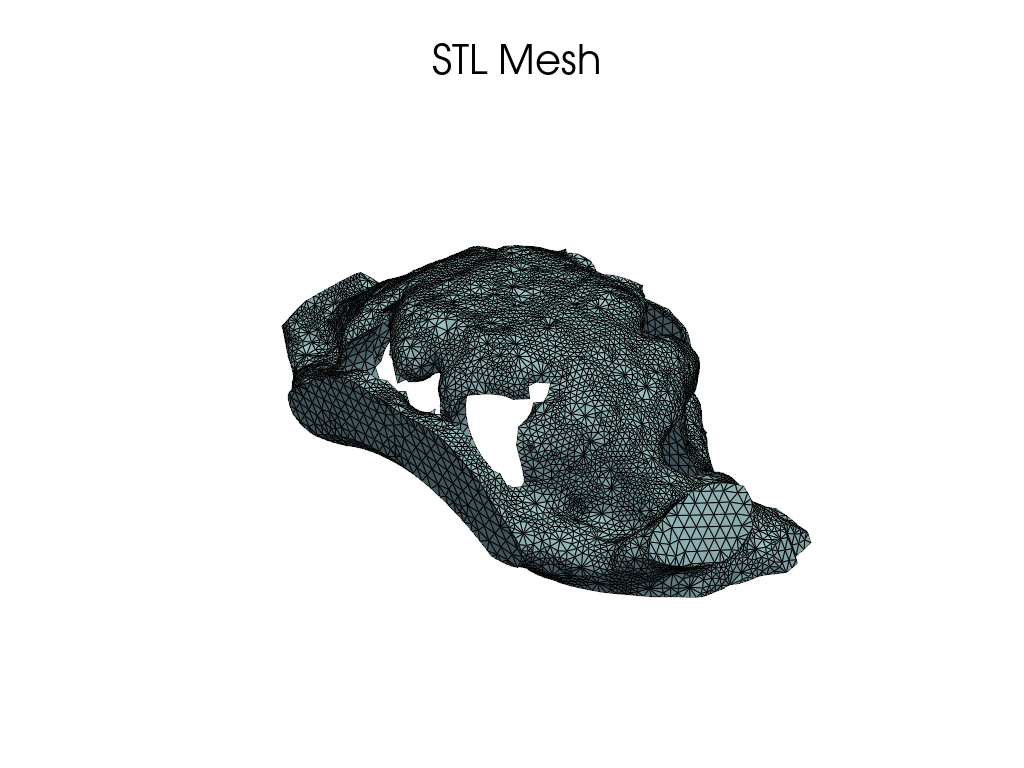

In [6]:
# 원본 mesh 시각화
plotter = pv.Plotter()
plotter.add_mesh(mesh, color='lightblue', show_edges=True, edge_color='black')
plotter.add_title("원본 STL Mesh", font_size=16)
plotter.show()

## 4. Point Cloud 추출 방법들

Surface mesh에서 point cloud를 추출하는 여러 가지 방법을 살펴보겠습니다.

### 4.1 방법 1: 모든 vertex 포인트 추출

In [7]:
# 모든 vertex 포인트 추출
vertices = mesh.points
print(f"추출된 vertex 포인트 수: {len(vertices):,}")
print(f"첫 5개 포인트:")
print(vertices[:5])

추출된 vertex 포인트 수: 11,908
첫 5개 포인트:
[[ -44.4    -169.121    97.7993]
 [ -44.4    -172.011    93.489 ]
 [ -44.4    -174.149    99.2445]
 [ -44.4    -102.235   109.464 ]
 [ -44.4     -95.664   106.31  ]]


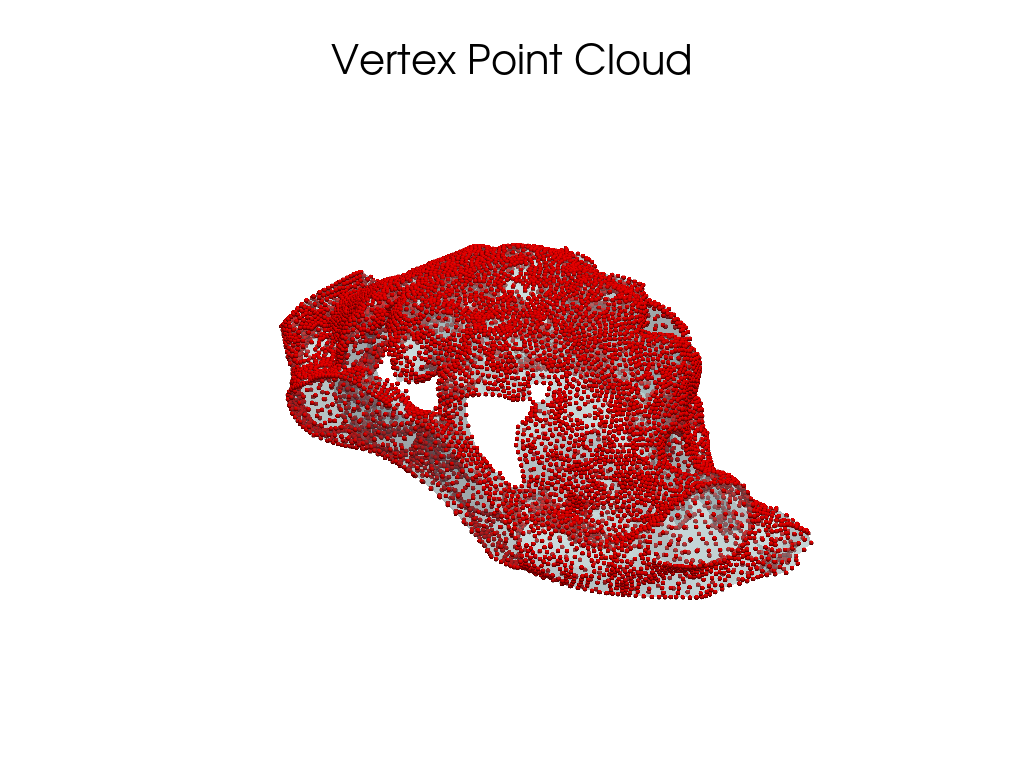

In [8]:
# vertex 포인트 시각화
vertex_cloud = pv.PolyData(vertices)

plotter = pv.Plotter()
plotter.add_mesh(mesh, color='lightblue', opacity=0.3, show_edges=False)
plotter.add_mesh(vertex_cloud, color='red', point_size=5, render_points_as_spheres=True)
plotter.add_title("Vertex Point Cloud", font_size=16)
plotter.show()

### 4.2 방법 2: Uniform Sampling으로 Point Cloud 생성

In [18]:
# Uniform sampling으로 point cloud 생성
n_points = 10000  # 원하는 포인트 수

# 방법 1: Random sampling on surface (올바른 방법)
uniform_points = mesh.sample(mesh.points)

# 또는 방법 2: 더 정확한 uniform sampling
# 먼저 mesh의 면적을 계산하고 균등하게 분포
surface_area = mesh.area
points_per_unit_area = n_points / surface_area

# 각 face에서 면적에 비례하여 포인트 생성
face_centers = mesh.cell_centers()
face_areas = mesh.compute_cell_sizes()['Area']
total_area = np.sum(face_areas)

# 각 face에서 생성할 포인트 수 계산
points_per_face = (face_areas / total_area * n_points).astype(int)
points_per_face = np.maximum(points_per_face, 1)  # 최소 1개씩은 생성

# 각 face에서 랜덤 포인트 생성
uniform_points_list = []
# 삼각형만 있다고 가정
for i in range(len(mesh.faces)//4):
    base_index = i*4
    v1 = mesh.points[mesh.faces[base_index+1]]
    v2 = mesh.points[mesh.faces[base_index+2]]
    v3 = mesh.points[mesh.faces[base_index+3]]

    # 삼각형 내에서 랜덤 포인트 생성
    r1, r2 = np.random.random(2)
    if r1 + r2 > 1:
        r1, r2 = 1 - r1, 1 - r2
    point = v1 + r1 * (v2 - v1) + r2 * (v3 - v1)
    uniform_points_list.append(point)

uniform_points = np.array(uniform_points_list)

print(f"Uniform sampling으로 생성된 포인트 수: {len(uniform_points):,}")
print(f"첫 5개 포인트:")
print(uniform_points[:5])

Uniform sampling으로 생성된 포인트 수: 23,846
첫 5개 포인트:
[[ -44.40000153 -170.8545691    97.20490754]
 [ -43.61751959 -100.84593301  108.79735163]
 [ -44.40000153  -96.26814383  107.50190954]
 [ -42.40869214 -150.84998762  110.91476231]
 [ -41.9319897  -150.72347212  111.92632044]]


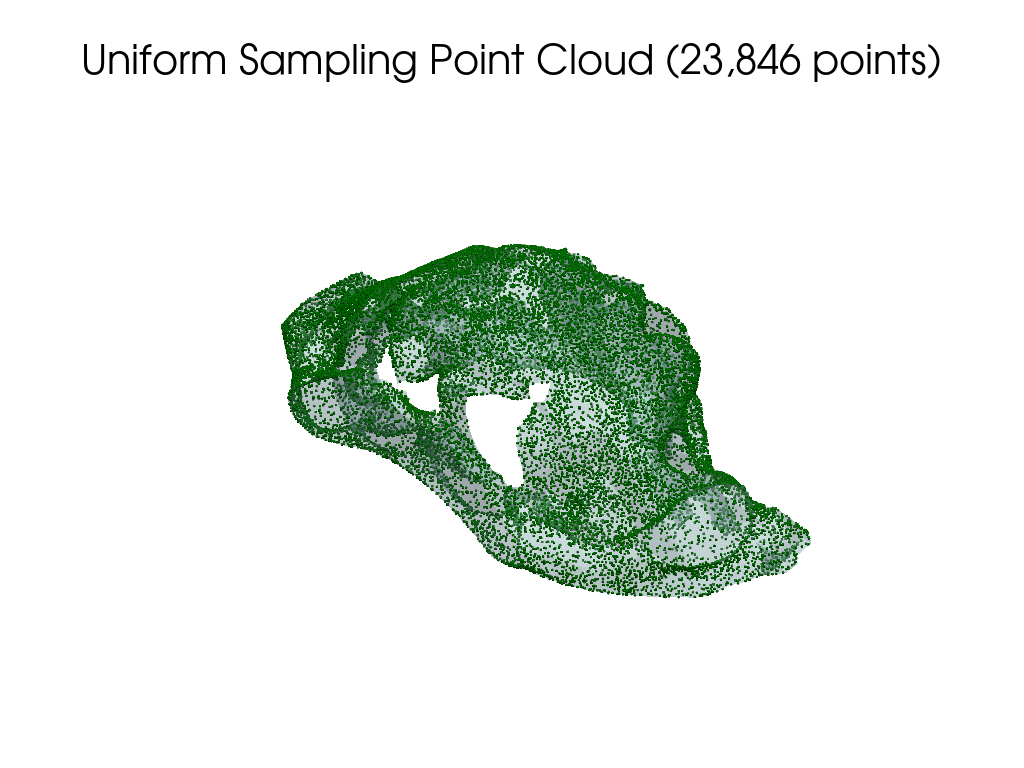

In [19]:
# Uniform sampling 결과 시각화
uniform_cloud = pv.PolyData(uniform_points)

plotter = pv.Plotter()
plotter.add_mesh(mesh, color='lightblue', opacity=0.3, show_edges=False)
plotter.add_mesh(uniform_cloud, color='green', point_size=3, render_points_as_spheres=True)
plotter.add_title(f"Uniform Sampling Point Cloud ({len(uniform_points):,} points)", font_size=16)
plotter.show()

### 4.3 방법 3: Face 중심점 추출

In [20]:
# 각 face의 중심점 추출
face_centers = mesh.cell_centers()
face_center_points = face_centers.points

print(f"Face 중심점 수: {len(face_center_points):,}")
print(f"첫 5개 face 중심점:")
print(face_center_points[:5])

Face 중심점 수: 23,846
첫 5개 face 중심점:
[[ -44.40000153 -171.76033529   96.84426626]
 [ -42.73333486  -99.32966614  108.069664  ]
 [ -44.40000153  -98.92066701  109.79799906]
 [ -41.64666748 -151.90199788  110.79499817]
 [ -42.5        -151.58533223  111.62333171]]


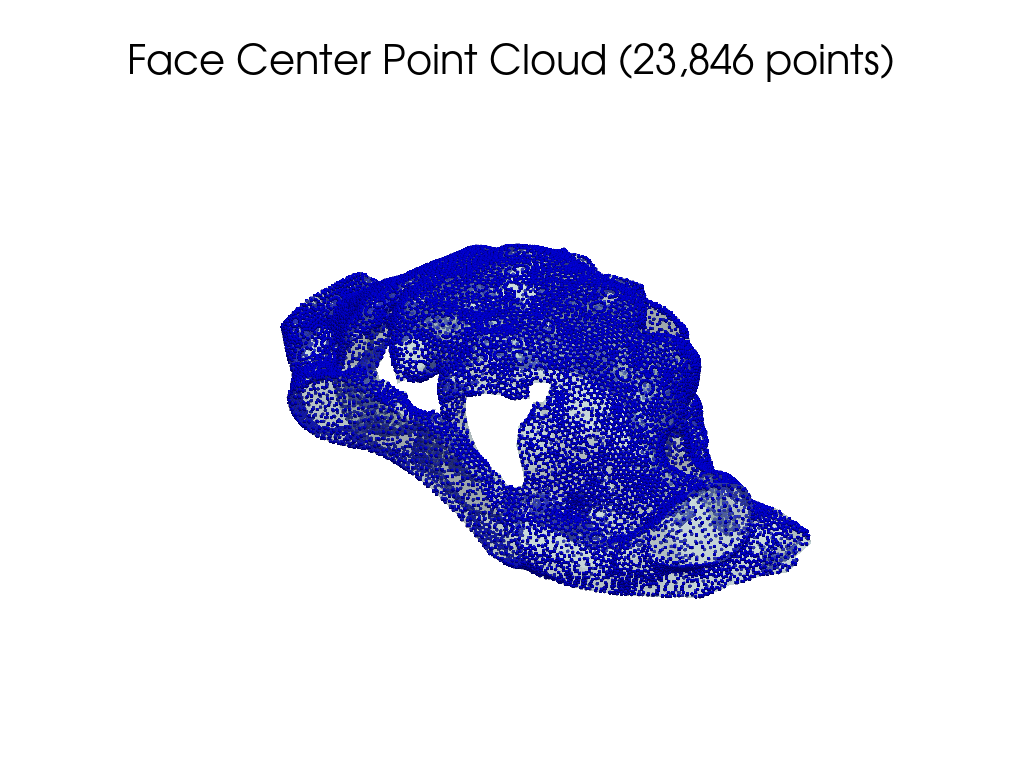

In [21]:
# Face 중심점 시각화
face_center_cloud = pv.PolyData(face_center_points)

plotter = pv.Plotter()
plotter.add_mesh(mesh, color='lightblue', opacity=0.3, show_edges=False)
plotter.add_mesh(face_center_cloud, color='blue', point_size=4, render_points_as_spheres=True)
plotter.add_title(f"Face Center Point Cloud ({len(face_center_points):,} points)", font_size=16)
plotter.show()

### 4.4 방법 4: Adaptive Sampling (밀도 기반)

In [27]:
import numpy as np

# 곡률 계산 ('mean', 'gaussian', 'maximum', 'minimum' 중 선택 가능)
# 'mean' or 'gaussian' commonly used
curvature = mesh.curvature(curv_type='mean')
mesh["curvature"] = curvature

# 3. 곡률 정규화 (0~1로 스케일링)
curv_norm = (curvature - curvature.min()) / (curvature.max() - curvature.min())

# 4. 곡률을 확률 분포로 변환 (곡률이 높을수록 샘플링 확률 증가)
sampling_prob = curv_norm / curv_norm.sum()

# 5. 샘플링할 점 개수 정의
num_samples = 5000

# 6. 확률적 샘플링
sample_indices = np.random.choice(
    mesh.n_points, size=num_samples, replace=False, p=sampling_prob)
sampled_points = mesh.points[sample_indices]

print(f"Adaptive sampling으로 생성된 포인트 수: {len(sampled_points):,}")

Adaptive sampling으로 생성된 포인트 수: 5,000


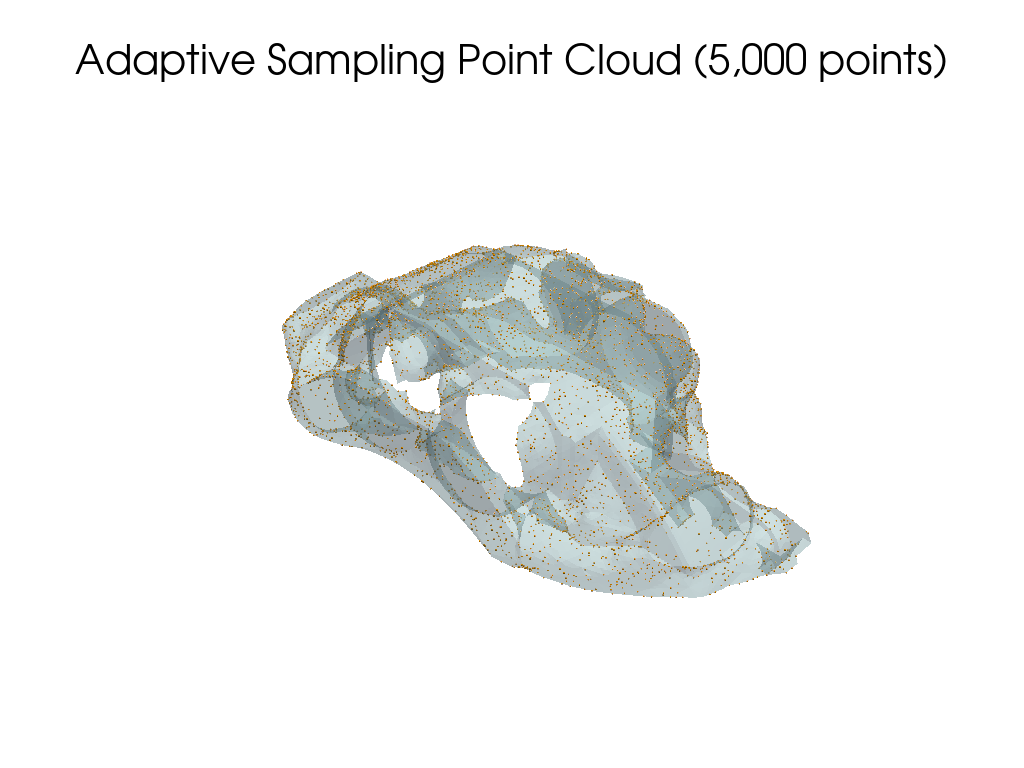

In [28]:
# Adaptive sampling 결과 시각화
adaptive_cloud = pv.PolyData(sampled_points)

plotter = pv.Plotter()
plotter.add_mesh(mesh, color='lightblue', opacity=0.3, show_edges=False)
plotter.add_mesh(adaptive_cloud, color='orange', point_size=2, render_points_as_spheres=True)
plotter.add_title(f"Adaptive Sampling Point Cloud ({len(sampled_points):,} points)", font_size=16)
plotter.show()

## 5. 모든 Point Cloud 방법 비교

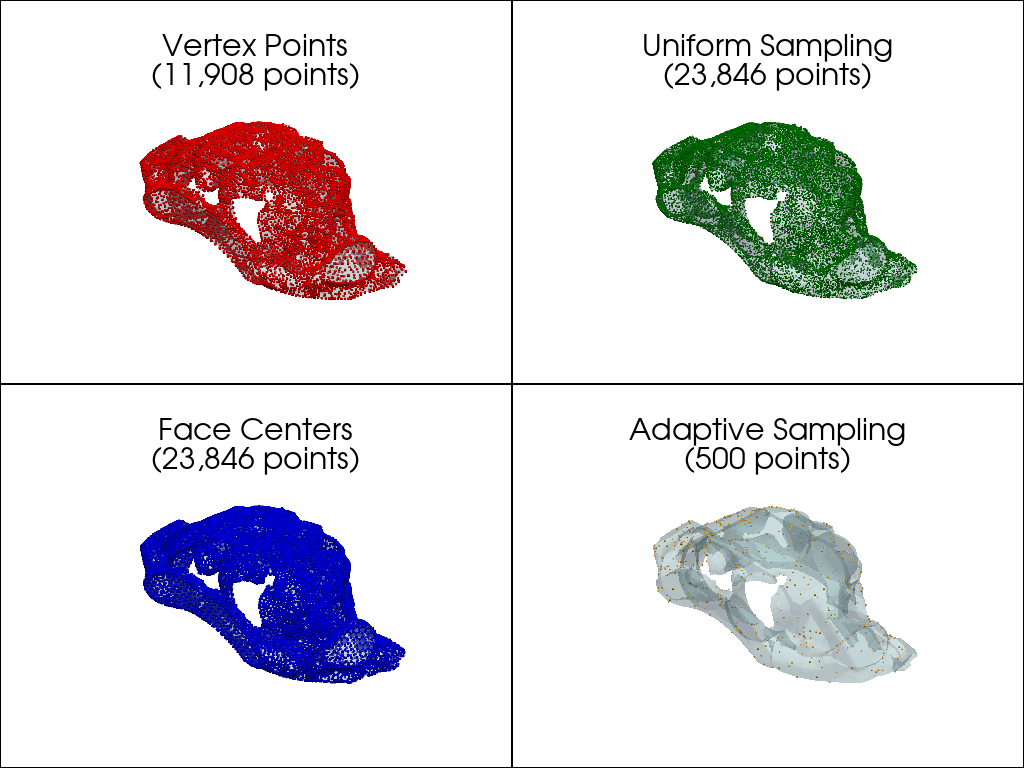

In [25]:
# 모든 방법의 결과를 한 번에 시각화
plotter = pv.Plotter(shape=(2, 2))

# 1. Vertex points
plotter.subplot(0, 0)
plotter.add_mesh(mesh, color='lightblue', opacity=0.3, show_edges=False)
plotter.add_mesh(vertex_cloud, color='red', point_size=3, render_points_as_spheres=True)
plotter.add_title(f"Vertex Points\n({len(vertices):,} points)", font_size=12)

# 2. Uniform sampling
plotter.subplot(0, 1)
plotter.add_mesh(mesh, color='lightblue', opacity=0.3, show_edges=False)
plotter.add_mesh(uniform_cloud, color='green', point_size=2, render_points_as_spheres=True)
plotter.add_title(f"Uniform Sampling\n({len(uniform_points):,} points)", font_size=12)

# 3. Face centers
plotter.subplot(1, 0)
plotter.add_mesh(mesh, color='lightblue', opacity=0.3, show_edges=False)
plotter.add_mesh(face_center_cloud, color='blue', point_size=3, render_points_as_spheres=True)
plotter.add_title(f"Face Centers\n({len(face_center_points):,} points)", font_size=12)

# 4. Adaptive sampling
plotter.subplot(1, 1)
plotter.add_mesh(mesh, color='lightblue', opacity=0.3, show_edges=False)
plotter.add_mesh(adaptive_cloud, color='orange', point_size=2, render_points_as_spheres=True)
plotter.add_title(f"Adaptive Sampling\n({len(sampled_points):,} points)", font_size=12)

plotter.show()

## 6. Point Cloud 저장

In [26]:
# Point cloud를 파일로 저장
output_dir = Path("../../data/point_clouds")
output_dir.mkdir(exist_ok=True)

# Uniform sampling 결과를 PLY 파일로 저장
uniform_cloud.save(str(output_dir / "10_30_uniform.ply"))
print(f"Uniform point cloud 저장됨: {output_dir / '10_30_uniform.ply'}")

# Vertex points를 PLY 파일로 저장
vertex_cloud.save(str(output_dir / "10_30_vertices.ply"))
print(f"Vertex point cloud 저장됨: {output_dir / '10_30_vertices.ply'}")

# Face centers를 PLY 파일로 저장
face_center_cloud.save(str(output_dir / "10_30_face_centers.ply"))
print(f"Face center point cloud 저장됨: {output_dir / '10_30_face_centers.ply'}")

# Adaptive sampling 결과를 PLY 파일로 저장
adaptive_cloud.save(str(output_dir / "10_30_adaptive.ply"))
print(f"Adaptive point cloud 저장됨: {output_dir / '10_30_adaptive.ply'}")

Uniform point cloud 저장됨: ../../data/point_clouds/10_30_uniform.ply
Vertex point cloud 저장됨: ../../data/point_clouds/10_30_vertices.ply
Face center point cloud 저장됨: ../../data/point_clouds/10_30_face_centers.ply
Adaptive point cloud 저장됨: ../../data/point_clouds/10_30_adaptive.ply


## 7. 요약

이 노트북에서 다룬 Point Cloud 추출 방법들:

1. **Vertex Points**: 메시의 모든 vertex를 추출 (가장 기본적인 방법)
2. **Uniform Sampling**: 균등하게 분포된 포인트 생성 (가장 일반적인 방법)
3. **Face Centers**: 각 face의 중심점 추출 (face 기반 분석에 유용)
4. **Adaptive Sampling**: 곡률이나 기하학적 특성에 따라 가중치를 적용한 sampling

각 방법은 용도에 따라 적절히 선택하여 사용하면 됩니다.